**MAESTRÍA EN INTELIGENCIA ARTIFICIAL APLICADA**

**Curso: TC4033 - Visión computacional para imágenes y video**

Tecnológico de Monterrey

Dr. Gilberto Ochoa Ruiz

**Semana 9**
Módulo 5. Segmentación de imágenes

9.6 Comparación de métodos de segmentación - Split & Merge

**EQUIPO 48**:

* José Alberto Rodríguez Sotomayor - A01796604
* André Maximiliano Hernández Bornn - A01795190
* César Armando Prieto Siller - A01796382
* Hector Magaña Torres - A00823440





### **Montar Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Instalar el CLI de **Kaggle**

In [ ]:
import os, stat, subprocess, glob, sys

SRC_TOKEN = "/content/drive/MyDrive/Equipo 48/Proyecto final/kaggle.json"
KAG_DIR   = "/root/.kaggle"
DEST_TOKEN = f"{KAG_DIR}/kaggle.json"
BASE_DIR  = "/content/data/covidct"
os.makedirs(BASE_DIR, exist_ok=True)

### Crear la carpeta de **credenciales** y descargar el **dataset**

In [ ]:
!pip -q install --upgrade kaggle

In [ ]:
import os, stat, subprocess, glob, sys

SRC_TOKEN = "/content/drive/MyDrive/Equipo 48/Proyecto final/kaggle.json"
KAG_DIR   = "/root/.kaggle"
DEST_TOKEN = f"{KAG_DIR}/kaggle.json"
BASE_DIR  = "/content/data/covidct"
os.makedirs(BASE_DIR, exist_ok=True)

# 1) Instalar/actualizar kaggle CLI
!pip -q install --upgrade kaggle

# 2) Copiar token y fijar permisos 600
assert os.path.exists(SRC_TOKEN), f"No encuentro tu kaggle.json en: {SRC_TOKEN}"
os.makedirs(KAG_DIR, exist_ok=True)
_ = os.system(f"cp '{SRC_TOKEN}' '{DEST_TOKEN}'")
os.chmod(DEST_TOKEN, stat.S_IRUSR | stat.S_IWUSR)

# Diagnóstico mínimo
print("Contenido de /root/.kaggle:", os.listdir(KAG_DIR))
!ls -l /root/.kaggle/

# 3) Probar autenticación
!kaggle --version

# 4) Descargar y descomprimir (forzar por si ya existía un zip corrupto)
print("\nDescargando dataset 'andrewmvd/covid19-ct-scans' ...")
rc = subprocess.call(f"kaggle datasets download -d andrewmvd/covid19-ct-scans -p {BASE_DIR} --force", shell=True)
if rc != 0:
    print("\n[Error] Falló la descarga. Revisa:\n - ¿Aceptaste los términos del dataset con ESTA cuenta?\n - ¿El token coincide con tu usuario (Settings > Create New API Token)?")
    sys.exit(1)

zips = glob.glob(os.path.join(BASE_DIR, "*.zip"))
assert zips, "No se encontró el .zip tras la descarga."
zip_path = zips[0]
_ = subprocess.call(f"unzip -o '{zip_path}' -d '{BASE_DIR}'", shell=True)
try:
    os.remove(zip_path)
except Exception as e:
    print("No se pudo borrar el zip (no crítico):", e)

# 5) Verificación rápida
import textwrap
all_csv = glob.glob(os.path.join(BASE_DIR, "**", "*.csv"), recursive=True)
all_nii = glob.glob(os.path.join(BASE_DIR, "**", "*.nii"), recursive=True)
print("\nOK. CSV detectados:", len(all_csv))
print(textwrap.indent("\n".join(all_csv[:5]) or "(ninguno)", "  "))
print("NIfTI .nii detectados:", len(all_nii))
print(textwrap.indent("\n".join(all_nii[:5]) or "(ninguno)", "  "))

Contenido de /root/.kaggle: ['kaggle.json']
total 4
-rw------- 1 root root 72 Nov 16 04:26 kaggle.json
Kaggle API 1.7.4.5

Descargando dataset 'andrewmvd/covid19-ct-scans' ...

OK. CSV detectados: 1
  /content/data/covidct/metadata.csv
NIfTI .nii detectados: 80
  /content/data/covidct/ct_scans/radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm.nii
  /content/data/covidct/ct_scans/coronacases_org_001.nii
  /content/data/covidct/ct_scans/coronacases_org_007.nii
  /content/data/covidct/ct_scans/radiopaedia_org_covid-19-pneumonia-29_86491_1-dcm.nii
  /content/data/covidct/ct_scans/coronacases_org_005.nii


### Verificar que el CLI **funciona**

In [ ]:
!kaggle --version

Kaggle API 1.7.4.5


### **Procesamiento**

In [ ]:
!pip -q install nibabel

import os, re, glob, math, numpy as np, pandas as pd, nibabel as nib
import cv2
import matplotlib.pyplot as plt

BASE_DIR = "/content/data/covidct"
CSV_PATH = os.path.join(BASE_DIR, "metadata.csv")

assert os.path.exists(CSV_PATH), f"No encuentro {CSV_PATH}"
meta = pd.read_csv(CSV_PATH)

# --- Helpers para resolver rutas locales ---
def basename_no_dirs(p):
    # toma el último nombre de archivo sin directorios de la ruta del CSV (que viene con ../input/...)
    return os.path.basename(str(p)).strip()

def local_path(kind, from_csv):
    # kind ∈ {"ct_scans","lung_mask","infection_mask","lung_and_infection_mask"}
    fname = basename_no_dirs(from_csv)
    candidate = os.path.join(BASE_DIR, kind, fname)
    if not os.path.exists(candidate):
        # fallback: buscar por nombre
        hits = glob.glob(os.path.join(BASE_DIR, kind, "**", fname), recursive=True)
        if hits:
            return hits[0]
    return candidate

# --- Elegir un caso (primera fila como demo) ---
row = meta.iloc[0]
ct_path  = local_path("ct_scans", row["ct_scan"])
li_path  = local_path("lung_and_infection_mask", row["lung_and_infection_mask"]) if "lung_and_infection_mask" in meta.columns else None

print("CT path:", ct_path, "existe:", os.path.exists(ct_path))
print("Lung+Infection mask:", li_path, "existe:", os.path.exists(li_path))

assert os.path.exists(ct_path), "No encontré el .nii del CT. Revisa estructura dentro de /content/data/covidct"
# Cargar volúmenes
ct_nii = nib.load(ct_path)
ct = ct_nii.get_fdata().astype(np.float32)  # shape: (H, W, D) o (X,Y,Z) según dataset

li = None
if li_path and os.path.exists(li_path):
    li_nii = nib.load(li_path)
    li = li_nii.get_fdata().astype(np.float32)

# Normalización simple por volumen → 8 bits (para visualización/criterios simples)
def norm8(vol):
    v = vol.copy()
    v = v - np.nanmin(v)
    vmax = np.nanmax(v)
    if vmax > 0:
        v = v / vmax
    return (v * 255.0).clip(0,255).astype(np.uint8)

ct8 = norm8(ct)

CT path: /content/data/covidct/ct_scans/coronacases_org_001.nii existe: True
Lung+Infection mask: /content/data/covidct/lung_and_infection_mask/coronacases_001.nii existe: True


### **Refinar Split & Merge con CLAHE, varianza adaptativa y limpieza**

Slices a procesar: [59, 149, 239] de 301


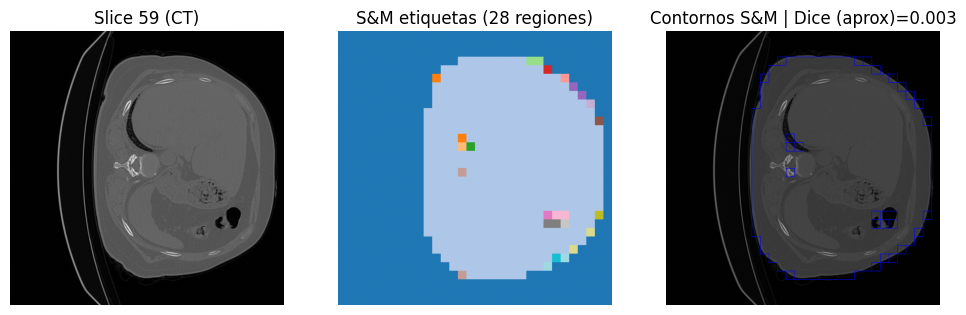

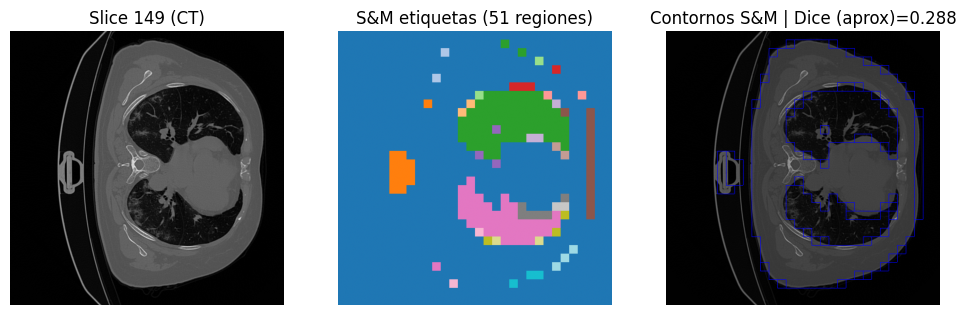

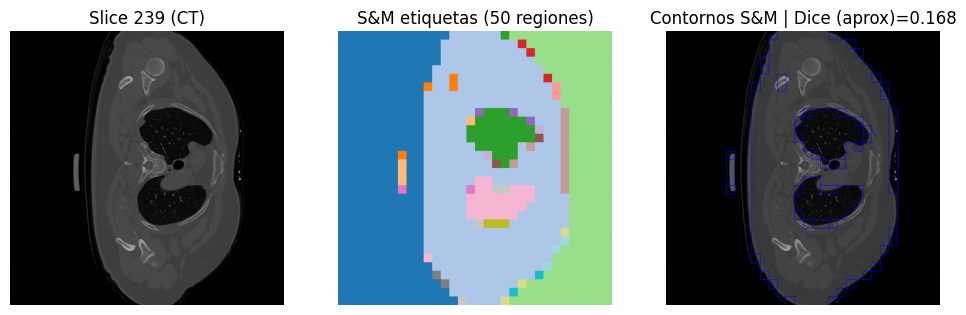


Listo. Ajusta var_thresh (split) y tol (merge) si se observa sobre/infra segmentación.


In [ ]:
# Seleccionar 3 cortes: basal (~20%), medio (~50%), apical (~80%) del eje de cortes
depth = ct8.shape[-1]
slices_idx = [max(0, int(0.2*depth)-1), max(0, int(0.5*depth)-1), max(0, int(0.8*depth)-1)]
print("Slices a procesar:", slices_idx, "de", depth)

# --- Implementación compacta de Split & Merge (varianza + fusión por media) ---
class Node:
    __slots__ = ("x","y","w","h","mean","var","children")
    def __init__(self,x,y,w,h): self.x,self.y,self.w,self.h=x,y,w,h; self.mean=0; self.var=0; self.children=[]

def region_stats(img, x, y, w, h):
    patch = img[y:y+h, x:x+w]
    # usar float para varianza
    return float(patch.mean()), float(patch.var())

def split(img, x, y, w, h, var_thresh=80.0, min_size=16):
    n = Node(x,y,w,h)
    n.mean, n.var = region_stats(img, x,y,w,h)
    if n.var <= var_thresh or min(w,h) <= min_size:
        return n
    hw, hh = w//2, h//2
    if hw==0 or hh==0:
        return n
    # 4 hijos (manejo de tamaños impares)
    n.children = [
        split(img, x,       y,       hw, hh, var_thresh, min_size),
        split(img, x+hw,    y,       w-hw, hh, var_thresh, min_size),
        split(img, x,       y+hh,    hw, h-hh, var_thresh, min_size),
        split(img, x+hw,    y+hh,    w-hw, h-hh, var_thresh, min_size),
    ]
    return n

def collect_leaves(node, out):
    if not node.children: out.append(node)
    else:
        for c in node.children: collect_leaves(c,out)

def label_leaves(shape, leaves):
    lab = -np.ones(shape, np.int32)
    for i,n in enumerate(leaves):
        lab[n.y:n.y+n.h, n.x:n.x+n.w] = i
    return lab

def neighbors4(label_map, rid):
    # busca en contorno de la región rid (vecindad 4 por barrido)
    ys, xs = np.where(label_map==rid)
    nbrs=set()
    for y,x in zip(ys,xs):
        if y>0 and label_map[y-1,x]!=rid:
            nb=label_map[y-1,x];
            if nb>=0: nbrs.add(nb)
        if y<label_map.shape[0]-1 and label_map[y+1,x]!=rid:
            nb=label_map[y+1,x];
            if nb>=0: nbrs.add(nb)
        if x>0 and label_map[y,x-1]!=rid:
            nb=label_map[y,x-1];
            if nb>=0: nbrs.add(nb)
        if x<label_map.shape[1]-1 and label_map[y,x+1]!=rid:
            nb=label_map[y,x+1];
            if nb>=0: nbrs.add(nb)
    return nbrs

def merge_by_mean(leaves, label_map, tol=10.0):
    means = np.array([l.mean for l in leaves], dtype=np.float32)
    parent = np.arange(len(leaves))
    def find(a):
        while parent[a]!=a:
            parent[a]=parent[parent[a]]; a=parent[a]
        return a
    def union(a,b):
        ra,rb=find(a),find(b)
        if ra!=rb: parent[rb]=ra
    for rid in range(len(leaves)):
        for nb in neighbors4(label_map,rid):
            if abs(means[rid]-means[nb])<=tol:
                union(rid,nb)
    # reetiquetar
    new_id={},0
    mapping={}
    nid=0
    mapped = label_map.copy()
    for r in range(len(leaves)):
        root=find(r)
        if root not in mapping:
            mapping[root]=nid; nid+=1
        mapped[mapped==r]=mapping[root]
    return mapped, nid

def overlay_boundaries(rgb, labels):
    g = labels
    bnd = np.zeros(g.shape, np.uint8)
    bnd[1:,:] |= (g[1:,:] != g[:-1,:])
    bnd[:,1:] |= (g[:,1:] != g[:,:-1])
    out = rgb.copy()
    out[bnd.astype(bool)] = (255,0,0)  # rojo
    return out

# --- Procesar y visualizar 3 slices ---
figs = []
for idx in slices_idx:
    sl = ct8[:,:,idx]
    sl_blur = cv2.GaussianBlur(sl, (5,5), 1.2)

    # Split (quadtree) + Merge
    root = split(sl_blur, 0,0, sl_blur.shape[1], sl_blur.shape[0], var_thresh=80.0, min_size=16)
    leaves=[]
    collect_leaves(root, leaves)
    lab = label_leaves(sl_blur.shape, leaves)
    merged, nreg = merge_by_mean(leaves, lab, tol=12.0)

    # Overlay
    rgb = cv2.cvtColor(sl, cv2.COLOR_GRAY2BGR)
    over = overlay_boundaries(rgb, merged)

    # Si hay máscara, calculamos Dice sobre el binarizado de Split&Merge (umbral por mayoritaria por región)
    dice_txt = ""
    if li is not None and li.ndim==3 and idx < li.shape[-1]:
        gt = (li[:,:,idx] > 0).astype(np.uint8)
        # convertir labels → binario por "promedio por región" > umbral
        bin_pred = np.zeros_like(gt)
        for r in np.unique(merged):
            if r<0: continue
            region = (merged==r)
            mean_val = sl_blur[region].mean()
            # umbral sencillo: media de todo el slice
            bin_pred[region] = 1 if mean_val < sl_blur.mean() else 0
        inter = (bin_pred & gt).sum()
        dice = (2*inter) / (bin_pred.sum() + gt.sum() + 1e-9)
        dice_txt = f" | Dice (aprox)={dice:.3f}"

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(sl, cmap='gray'); plt.title(f"Slice {idx} (CT)"); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(merged, cmap='tab20'); plt.title(f"S&M etiquetas ({nreg} regiones)"); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(over[...,::-1]); plt.title(f"Contornos S&M{dice_txt}"); plt.axis('off')
    plt.show()

print("\nListo. Ajusta var_thresh (split) y tol (merge) si se observa sobre/infra segmentación.")

### **Ajustar percentil de varianza y tolerancia de merge (con demostración de etapa split y etapa de merge)**

Varianza adaptativa: 614.0


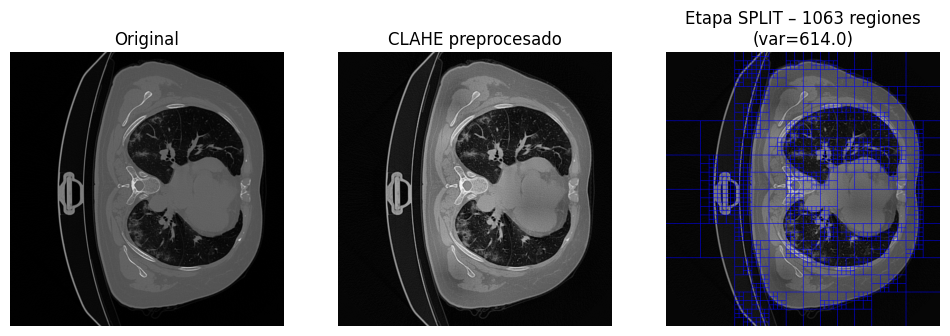

In [ ]:
# === CELDA 1: Etapa de SPLIT ===
idx = 149  # slice medio; ajustar si deseamos otro corte
sl = ct8[:,:,idx]

# 1) Preprocesamiento con CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
sl_eq = clahe.apply(sl)

# 2) Calcular umbral adaptativo de varianza
var_map = []
step = 64
for y in range(0, sl_eq.shape[0], step):
    for x in range(0, sl_eq.shape[1], step):
        patch = sl_eq[y:y+step, x:x+step]
        var_map.append(patch.var())
var_thresh = np.percentile(var_map, 35)  # 35º percentil de varianza típica
print(f"Varianza adaptativa: {var_thresh:.1f}")

# 3) Aplicar sólo SPLIT (sin merge todavía)
root = split(sl_eq, 0, 0, sl_eq.shape[1], sl_eq.shape[0],
             var_thresh=var_thresh, min_size=8)
leaves = []
collect_leaves(root, leaves)
lab_split = label_leaves(sl_eq.shape, leaves)

# 4) Visualización de la etapa SPLIT
rgb_split = cv2.cvtColor(sl_eq, cv2.COLOR_GRAY2BGR)
bnd_split = np.zeros_like(sl_eq)
bnd_split[1:,:] |= (lab_split[1:,:] != lab_split[:-1,:])
bnd_split[:,1:] |= (lab_split[:,1:] != lab_split[:,:-1])
over_split = rgb_split.copy()
over_split[bnd_split.astype(bool)] = (255,0,0)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(sl, cmap='gray'); plt.title("Original"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(sl_eq, cmap='gray'); plt.title("CLAHE preprocesado"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(over_split[...,::-1]);
plt.title(f"Etapa SPLIT – {len(leaves)} regiones\n(var={var_thresh:.1f})")
plt.axis('off')
plt.show()


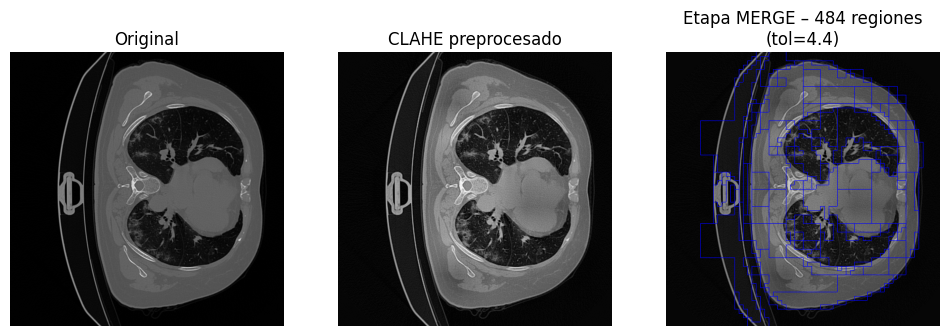

In [ ]:
# === CELDA 2: Etapa de MERGE ===

# 1) Aplicar la fusión (Merge) con tolerancia basada en brillo promedio
tol = sl_eq.mean() * 0.1  # 10% del brillo medio
merged, nreg = merge_by_mean(leaves, lab_split, tol=tol)

# 2) Limpieza morfológica (opcional)
min_area = 200
unique_ids, counts = np.unique(merged, return_counts=True)
small = unique_ids[counts < min_area]
mask_small = np.isin(merged, small)
merged[mask_small] = -1  # eliminar regiones diminutas

# 3) Visualización de la etapa MERGE
rgb_merge = cv2.cvtColor(sl_eq, cv2.COLOR_GRAY2BGR)
over_merge = overlay_boundaries(rgb_merge, merged)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(sl, cmap='gray'); plt.title("Original"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(sl_eq, cmap='gray'); plt.title("CLAHE preprocesado"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(over_merge[...,::-1]);
plt.title(f"Etapa MERGE – {nreg} regiones\n(tol={tol:.1f})"); plt.axis('off')
plt.show()


## **Batch de slices**

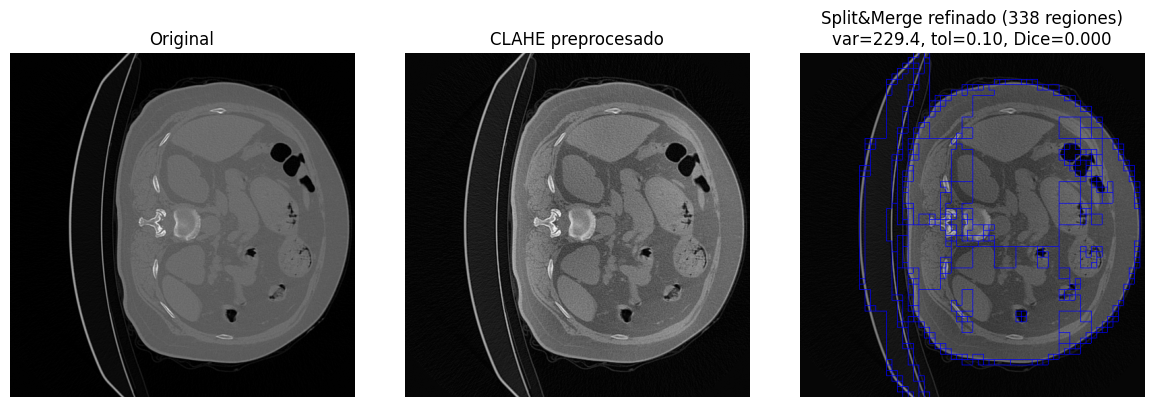

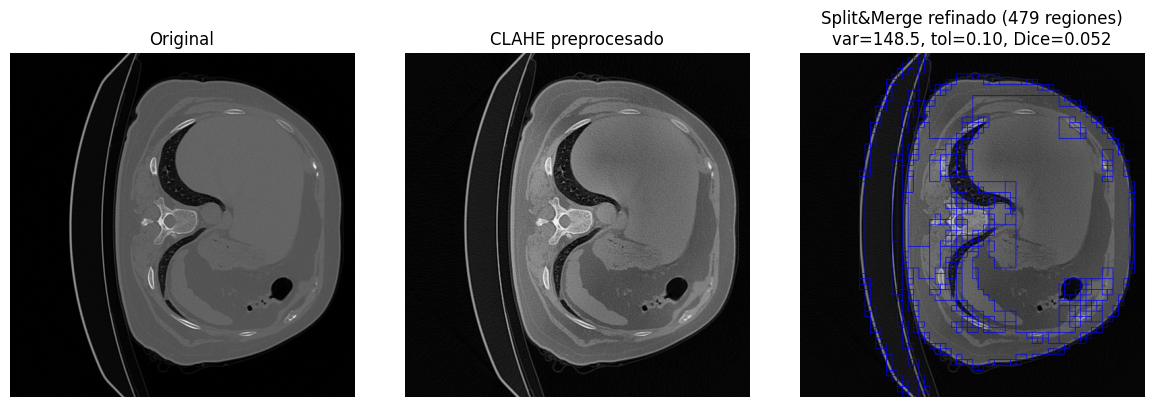

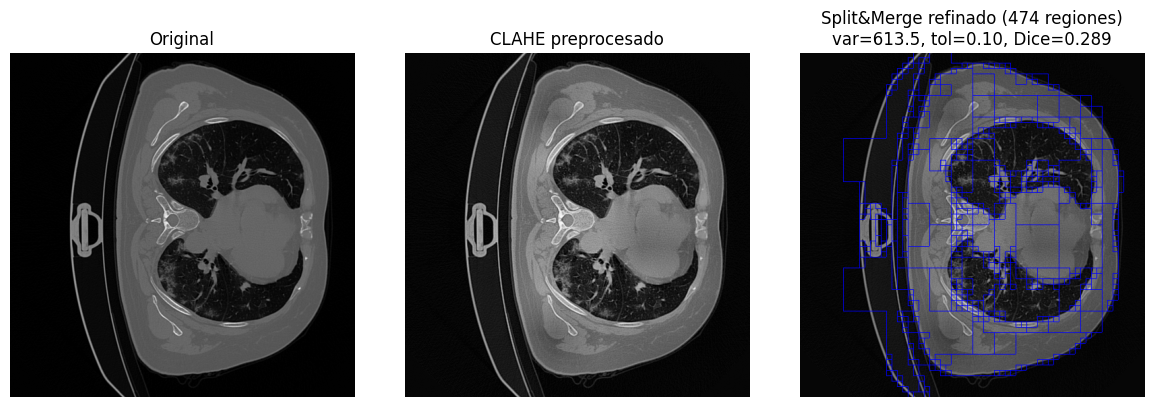

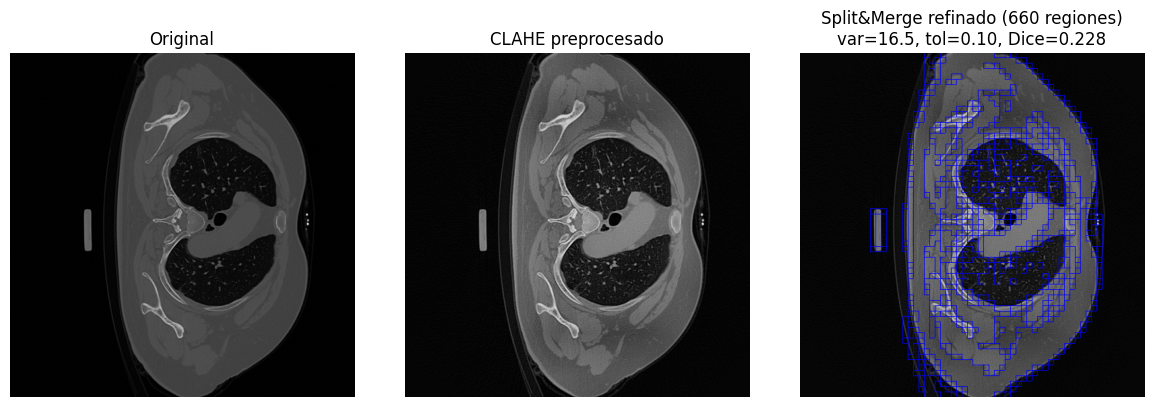

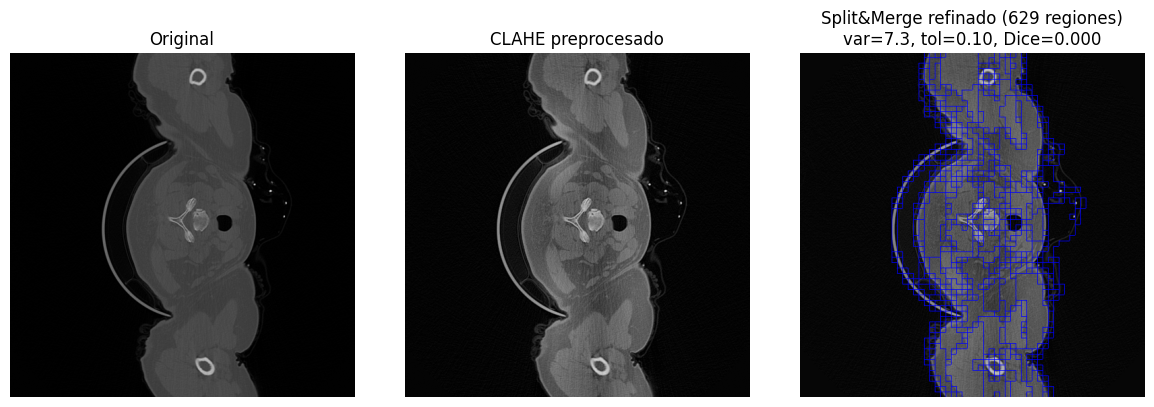

Hecho.
- Imágenes guardadas en: /content/drive/MyDrive/Equipo 48/Proyecto final/resultados
- CSV de métricas: /content/drive/MyDrive/Equipo 48/Proyecto final/resultados/metrics_case0.csv

Resumen:
   slice  var_thresh  merge_rel_tol  min_size  regions      dice       iou  \
0      0  229.413235            0.1         8      338  0.000000  0.000000   
1     75  148.454527            0.1         8      479  0.051707  0.026539   
2    150  613.507130            0.1         8      474  0.289412  0.169189   
3    225   16.502813            0.1         8      660  0.228287  0.128851   
4    300    7.269327            0.1         8      629  0.000000  0.000000   

                                         figure_path  
0  /content/drive/MyDrive/Equipo 48/Proyecto fina...  
1  /content/drive/MyDrive/Equipo 48/Proyecto fina...  
2  /content/drive/MyDrive/Equipo 48/Proyecto fina...  
3  /content/drive/MyDrive/Equipo 48/Proyecto fina...  
4  /content/drive/MyDrive/Equipo 48/Proyecto fina...  

Dic

In [ ]:
# ---------- Paths ----------
BASE_DIR = "/content/data/covidct"
CSV_PATH = os.path.join(BASE_DIR, "metadata.csv")
SAVE_DIR = "/content/drive/MyDrive/Equipo 48/Proyecto final/resultados"
os.makedirs(SAVE_DIR, exist_ok=True)

# ---------- Parámetros Split & Merge ----------
PERCENTILE_VAR = 35          # varianza adaptativa (p35)
MERGE_REL_TOL = 0.10         # 10% de la media del slice
MIN_SIZE = 8                  # tamaño mínimo de bloque (px)
CLAHE_CLIP = 2.0              # CLAHE
CLAHE_TILE = (8,8)
N_SLICES = 5                  # cuántos slices tomamos (uniformemente espaciados)

# ---------- Utilidades previas ----------
def basename_no_dirs(p): return os.path.basename(str(p)).strip()
def local_path(kind, from_csv):
    fname = basename_no_dirs(from_csv)
    cand = os.path.join(BASE_DIR, kind, fname)
    if os.path.exists(cand): return cand
    hits = glob.glob(os.path.join(BASE_DIR, kind, "**", fname), recursive=True)
    return hits[0] if hits else cand

def norm8(vol):
    v = vol.astype(np.float32)
    v = v - np.nanmin(v); vmax = np.nanmax(v)
    if vmax>0: v /= vmax
    return (v*255.0).clip(0,255).astype(np.uint8)

class Node:
    __slots__=("x","y","w","h","mean","var","children")
    def __init__(self,x,y,w,h): self.x,self.y,self.w,self.h=x,y,w,h; self.mean=0; self.var=0; self.children=[]
def region_stats(img,x,y,w,h):
    p = img[y:y+h, x:x+w]; return float(p.mean()), float(p.var())
def split(img,x,y,w,h,var_thresh=80.0,min_size=16):
    n=Node(x,y,w,h); n.mean,n.var=region_stats(img,x,y,w,h)
    if n.var<=var_thresh or min(w,h)<=min_size: return n
    hw,hh=w//2,h//2
    if hw==0 or hh==0: return n
    n.children=[
        split(img,x,      y,      hw,hh,var_thresh,min_size),
        split(img,x+hw,   y,      w-hw,hh,var_thresh,min_size),
        split(img,x,      y+hh,   hw,h-hh,var_thresh,min_size),
        split(img,x+hw,   y+hh,   w-hw,h-hh,var_thresh,min_size),
    ]; return n
def collect_leaves(node,out):
    if not node.children: out.append(node)
    else:
        for c in node.children: collect_leaves(c,out)
def label_leaves(shape, leaves):
    lab = -np.ones(shape, np.int32)
    for i,n in enumerate(leaves):
        lab[n.y:n.y+n.h, n.x:n.x+n.w] = i
    return lab
def neighbors4(label_map, rid):
    ys,xs = np.where(label_map==rid); nbrs=set(); H,W=label_map.shape
    for y,x in zip(ys,xs):
        if y>0 and label_map[y-1,x]!=rid: nb=label_map[y-1,x];
        else: nb=None
        if nb is not None and nb>=0: nbrs.add(nb)
        if y<H-1 and label_map[y+1,x]!=rid:
            nb=label_map[y+1,x];
            if nb>=0: nbrs.add(nb)
        if x>0 and label_map[y,x-1]!=rid:
            nb=label_map[y,x-1];
            if nb>=0: nbrs.add(nb)
        if x<W-1 and label_map[y,x+1]!=rid:
            nb=label_map[y,x+1];
            if nb>=0: nbrs.add(nb)
    return nbrs
def merge_by_mean(leaves, label_map, tol):
    means = np.array([l.mean for l in leaves], np.float32)
    parent = np.arange(len(leaves))
    def find(a):
        while parent[a]!=a: parent[a]=parent[parent[a]]; a=parent[a]
        return a
    def union(a,b):
        ra,rb=find(a),find(b)
        if ra!=rb: parent[rb]=ra
    for rid in range(len(leaves)):
        for nb in neighbors4(label_map,rid):
            if abs(means[rid]-means[nb])<=tol: union(rid,nb)
    mapping={}; nid=0
    mapped = label_map.copy()
    for r in range(len(leaves)):
        root=find(r)
        if root not in mapping: mapping[root]=nid; nid+=1
        mapped[mapped==r]=mapping[root]
    return mapped, nid
def overlay_boundaries(gray_or_rgb, labels):
    if gray_or_rgb.ndim==2: rgb = cv2.cvtColor(gray_or_rgb, cv2.COLOR_GRAY2BGR)
    else: rgb = gray_or_rgb.copy()
    g=labels; bnd=np.zeros(g.shape,np.uint8)
    bnd[1:,:] |= (g[1:,:]!=g[:-1,:]); bnd[:,1:] |= (g[:,1:]!=g[:,:-1])
    out = rgb.copy(); out[bnd.astype(bool)] = (255,0,0)
    return out

# ---------- Carga metadata y volúmenes ----------
meta = pd.read_csv(CSV_PATH)
row = meta.iloc[0]  # usa el primer caso del CSV
ct_path = local_path("ct_scans", row["ct_scan"])
li_path = local_path("lung_and_infection_mask", row.get("lung_and_infection_mask","")) \
          if "lung_and_infection_mask" in meta.columns else None
lung_only_path = local_path("lung_mask", row.get("lung_mask","")) if "lung_mask" in meta.columns else None

assert os.path.exists(ct_path), f"No encontré CT: {ct_path}"
ct = nib.load(ct_path).get_fdata().astype(np.float32)  # (H,W,D)
ct8 = norm8(ct)
mask_vol = None
if li_path and os.path.exists(li_path):
    mask_vol = nib.load(li_path).get_fdata().astype(np.float32)
elif lung_only_path and os.path.exists(lung_only_path):
    mask_vol = nib.load(lung_only_path).get_fdata().astype(np.float32)

H,W,D = ct8.shape
slice_ids = np.linspace(0, D-1, N_SLICES, dtype=int).tolist()

results = []
clahe = cv2.createCLAHE(clipLimit=CLAHE_CLIP, tileGridSize=CLAHE_TILE)

for idx in slice_ids:
    sl = ct8[:,:,idx]
    sl_eq = clahe.apply(sl)

    # Varianza adaptativa por bloques
    var_samples=[]
    step=64
    for y in range(0,H,step):
        for x in range(0,W,step):
            var_samples.append(sl_eq[y:y+step, x:x+step].var())
    var_thresh = float(np.percentile(var_samples, PERCENTILE_VAR))

    # Split & Merge
    root = split(sl_eq, 0,0,W,H, var_thresh=var_thresh, min_size=MIN_SIZE)
    leaves=[]; collect_leaves(root, leaves)
    lab = label_leaves(sl_eq.shape, leaves)
    tol = sl_eq.mean()*MERGE_REL_TOL
    merged, nreg = merge_by_mean(leaves, lab, tol=tol)

    # Binario (pulmón) por Otsu a nivel slice y asignación por región
    thr, _ = cv2.threshold(sl_eq, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    thr = float(thr)   # Otsu devuelve umbral en [0,255]
    bin_pred = np.zeros_like(sl_eq, dtype=np.uint8)
    for r in np.unique(merged):
        if r<0: continue
        region = (merged==r)
        if sl_eq[region].mean() < thr:   # pulmón es más oscuro (aire)
            bin_pred[region] = 1

    # Métricas contra ground truth (si hay)
    dice = iou = np.nan
    if mask_vol is not None and idx < mask_vol.shape[-1]:
        gt = (mask_vol[:,:,idx] > 0).astype(np.uint8)
        inter = int((bin_pred & gt).sum())
        dice = (2*inter) / (int(bin_pred.sum()) + int(gt.sum()) + 1e-9)
        union = int((bin_pred | gt).sum())
        iou = inter / (union + 1e-9)

    # Guardar y mostrar figuras
    fig = plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(sl, cmap='gray'); plt.title("Original"); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(sl_eq, cmap='gray'); plt.title("CLAHE preprocesado"); plt.axis('off')
    over = overlay_boundaries(sl_eq, merged)
    ttl = f"Split&Merge refinado ({nreg} regiones)\nvar={var_thresh:.1f}, tol={MERGE_REL_TOL:.2f}, Dice={dice:.3f}"
    plt.subplot(1,3,3); plt.imshow(over[...,::-1]); plt.title(ttl); plt.axis('off')
    fname = os.path.join(SAVE_DIR, f"case0_slice{idx:03d}.png")
    plt.tight_layout()

    #Mostrar la figura directamente en el notebook
    plt.show()

    #Guardar la figura en Drive
    fname = os.path.join(SAVE_DIR, f"case0_slice{idx:03d}.png")
    fig.savefig(fname,dpi = 180)
    plt.close(fig)

    #Registrar resultados
    results.append({
        "slice": idx,
        "var_thresh": var_thresh,
        "merge_rel_tol": MERGE_REL_TOL,
        "min_size": MIN_SIZE,
        "regions": int(nreg),
        "dice": float(dice) if not np.isnan(dice) else None,
        "iou": float(iou) if not np.isnan(iou) else None,
        "figure_path": fname
    })

# ---------- Exportar CSV con métricas ----------
df = pd.DataFrame(results)
csv_out = os.path.join(SAVE_DIR, "metrics_case0.csv")
df.to_csv(csv_out, index=False)

print("Hecho.")
print(f"- Imágenes guardadas en: {SAVE_DIR}")
print(f"- CSV de métricas: {csv_out}")
print("\nResumen:")
print(df)
if df["dice"].notna().any():
    print(f"\nDice promedio (sólo slices con GT): {df['dice'].dropna().mean():.3f}")
